# Process NRCS Additional Sites

### Prepare Workspace

In [1]:
# Import system libraries
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Import data manipulation librariaes
import datetime
import pandas as pd
import numpy as np

# Import geospatial libraries
from shapely.geometry import Point, Polygon
import geopandas as gpd
import rioxarray

# Import API libraries
import requests

# Import progress bar
from tqdm import tqdm

# Set working directory
os.chdir('/Users/jessicarapson/Documents/GitHub/water-supply-forecast')

### Load Data from Files

In [10]:
# Load original sites
mflow_orig = pd.read_csv('assets/data/train_monthly_naturalized_flow.csv')
metad_orig = pd.read_csv('assets/data/metadata.csv')

# Load additional sites
mflow_ncrs = pd.read_csv('assets/data/supplementary_nrcs_train_monthly_naturalized_flow.csv')
metad_ncrs = pd.read_csv('assets/data/supplementary_nrcs_metadata.csv')

# Transform data for combination
mflow_ncrs = mflow_ncrs.rename(columns={'nrcs_id': 'site_id'})
metad_ncrs = metad_ncrs.rename(columns={'nrcs_id': 'site_id'})
metad_ncrs['season_start_month'] = 4
metad_ncrs['season_end_month'] = 7
metad_orig = metad_orig[metad_ncrs.columns]

# Combine dataframes
all_mflow = pd.concat([mflow_orig, mflow_ncrs], ignore_index=True)
all_metad = pd.concat([metad_orig, metad_ncrs], ignore_index=True)

### Add HydroBASIN Data

In [103]:
# Load in attribute geospatial data (this takes a while)
gdf_basins = gpd.read_file('assets/data/additional_sites/hydroBASINS_additional.gpkg')

# Convert coordinates to geometry
geometry = [Point(xy) for xy in zip(all_metad['longitude'], all_metad['latitude'])]
gdf_sites = gpd.GeoDataFrame(all_metad, geometry=geometry, crs=gdf_basins.crs)

# Select columns of interest
cols_int = ['inu_pc_smn','inu_pc_smx','inu_pc_slt','inu_pc_umn','inu_pc_umx',
            'inu_pc_ult','lka_pc_sse','lka_pc_use','dor_pc_pva','slp_dg_sav',
            'slp_dg_uav','sgr_dk_sav','tmp_dc_uyr','ari_ix_sav','ari_ix_uav',
            'cmi_ix_uyr','snw_pc_uyr','glc_pc_s01','glc_pc_s02','glc_pc_s03',
            'glc_pc_s04','glc_pc_s05','glc_pc_s06','glc_pc_s07','glc_pc_s08',
            'glc_pc_s09','glc_pc_s10','glc_pc_s11','glc_pc_s12','glc_pc_s13',
            'glc_pc_s14','glc_pc_s15','glc_pc_s16','glc_pc_s17','glc_pc_s18',
            'glc_pc_s19','glc_pc_s20','glc_pc_s21','glc_pc_s22','glc_pc_u01',
            'glc_pc_u02','glc_pc_u03','glc_pc_u04','glc_pc_u05','glc_pc_u06',
            'glc_pc_u07','glc_pc_u08','glc_pc_u09','glc_pc_u10','glc_pc_u11',
            'glc_pc_u12','glc_pc_u13','glc_pc_u14','glc_pc_u15','glc_pc_u16',
            'glc_pc_u17','glc_pc_u18','glc_pc_u19','glc_pc_u20','glc_pc_u21',
            'glc_pc_u22','wet_pc_sg1','wet_pc_sg2','wet_pc_ug1','wet_pc_ug2',
            'for_pc_sse','for_pc_use','crp_pc_sse','crp_pc_use','pst_pc_sse',
            'pst_pc_use','ire_pc_sse','ire_pc_use','gla_pc_sse','gla_pc_use',
            'prm_pc_sse','prm_pc_use','pac_pc_sse','pac_pc_use','cly_pc_sav',
            'cly_pc_uav','slt_pc_sav','slt_pc_uav','snd_pc_sav','snd_pc_uav',
            'soc_th_sav','soc_th_uav','swc_pc_syr','swc_pc_uyr','swc_pc_s01',
            'swc_pc_s02','swc_pc_s03','swc_pc_s04','swc_pc_s05','swc_pc_s06',
            'swc_pc_s07','swc_pc_s08','swc_pc_s09','swc_pc_s10','swc_pc_s11',
            'swc_pc_s12','kar_pc_sse','kar_pc_use','ero_kh_sav','ero_kh_uav',
            'ppd_pk_sav','ppd_pk_uav','urb_pc_sse','urb_pc_use','nli_ix_sav',
            'nli_ix_uav','rdd_mk_sav','rdd_mk_uav','hft_ix_s93','hft_ix_u93',
            'hft_ix_s09','hft_ix_u09','gwt_cm_sav','run_mm_syr','lkv_mc_usu',
            'rev_mc_usu','ria_ha_ssu','ria_ha_usu','riv_tc_ssu','riv_tc_usu',
            'pre_mm_uyr','pet_mm_syr','pet_mm_s01', 'pet_mm_s02','pet_mm_s03',
            'pet_mm_s04','pet_mm_s05','pet_mm_s06','pet_mm_s07','pet_mm_s08',
            'pet_mm_s09','pet_mm_s10','pet_mm_s11','pet_mm_s12','pet_mm_uyr',
            'aet_mm_syr','aet_mm_s01','aet_mm_s02','aet_mm_s03','aet_mm_s04',
            'aet_mm_s05','aet_mm_s06','aet_mm_s07','aet_mm_s08','aet_mm_s09',
            'aet_mm_s10','aet_mm_s11','aet_mm_s12','aet_mm_uyr','pop_ct_ssu',
            'pop_ct_usu','clz_cl_smj','cls_cl_smj','glc_cl_smj','pnv_cl_smj',
            'wet_cl_smj','tbi_cl_smj','tec_cl_smj','fmh_cl_smj','fec_cl_smj',
            'lit_cl_smj', 'SUB_AREA', 'UP_AREA','COAST','ORDER_','ENDO','geometry']

# Join relevant basin data
gdf_join = gpd.sjoin(gdf_sites, gdf_basins[cols_int], how='left', op='within')

# Code missing values as NaN
gdf_join = gdf_join.replace(-9999, np.nan)

# Replace points with basin polygon
polygons = gdf_join.merge(gdf_basins, how='left', left_on='index_right', right_index=True)
gdf_join.geometry = polygons.geometry_y

# Drop extra columns
cols_drop = ['nrcs_name', 'usgs_id', 'elevation', 'latitude', 'longitude',
             'season_start_month', 'season_end_month', 'geometry', 'index_right']
gdf_join = gdf_join.drop(cols_drop, axis=1)

# Convert categorical columns to strings
cols_cat = ['COAST', 'ORDER_', 'ENDO', 'clz_cl_smj', 'cls_cl_smj',
            'glc_cl_smj', 'pnv_cl_smj', 'wet_cl_smj', 'tbi_cl_smj',
            'tec_cl_smj', 'fmh_cl_smj', 'fec_cl_smj', 'lit_cl_smj']
gdf_join[cols_cat] = gdf_join[cols_cat].astype(str)

### Add SWANN Data

In [162]:
# Select years
START_YEAR = 1981
END_YEAR = 2023
YEARS = [y for y in range(START_YEAR, END_YEAR)]

# Select data
ROOT = 'https://climate.arizona.edu/data/UA_SWE/'
LOCATION = 'data/swann'

# Download data
os.makedirs(LOCATION, exist_ok=True)
for yr in tqdm(YEARS):
    fn = f'UA_SWE_Depth_WY{yr}.nc'
    url = ROOT + '/' + fn
    target = os.path.join(LOCATION, fn)
    with open(target, 'wb') as f:
        response = requests.get(url, verify=False)
        f.write(response.content)

swe_volumes = []
for yr in tqdm(YEARS):
    fn = os.path.join('data/swann', f'UA_SWE_Depth_WY{yr}.nc')
    try:
        ds = rioxarray.open_rasterio(fn, variable='SWE', mask_and_scale=True)
    except IOError:
        continue

    # Perform an initial clip to reduce the size of the array
    ds = ds.rio.write_crs(4326)
    ds = ds.rio.reproject("EPSG:4326")

    ds['SWE'] /= 1000  # mm -> m
    ds = ds.fillna(0)
    ds = ds.rio.write_crs(4326)
    ds_clipped_rgn = ds.rio.clip(gdf_join.geometry.values)

    for i in range(0, len(gdf_join)):
        try:
            # Clip to current polygon
            ds_clipped_poly = ds_clipped_rgn.rio.clip([gdf_join.iloc[i].geometry])

            # Set -999 to nan then convert to dataframe
            df = ds_clipped_poly.to_dataframe()
            df = df.dropna()
            df = df.reset_index()

            # Group by time and average over grid cells
            swe_vol = df.groupby(['time'])['SWE'].mean()

            # Format dataframe
            swe_vol = pd.DataFrame(swe_vol).reset_index()
            swe_vol['site_id'] = gdf_join.iloc[i].site_id
            swe_vol = swe_vol.set_index(['site_id', 'time'])
            swe_vol = swe_vol.rename({'SWE': 'SWE_depth_m'}, axis=1)
            swe_volumes.append(swe_vol)
        except Exception as e:
            print(f"No data found for: {gdf_join.iloc[i]['site_id']}")
            continue

# Concatenate dataframes and write output
swe_volumes = pd.concat(swe_volumes, axis=0)
swe_volumes.to_csv("assets/data/additional_sites/swann_swe.csv")

# Filter to years of interest
swe_volumes_week = swe_volumes.copy()
swe_volumes_week['date'] = pd.to_datetime(swe_volumes['time']).dt.date
swe_volumes_week = swe_volumes_week[pd.to_datetime(
    swe_volumes_week['date']) >= pd.Timestamp("1985-01-01")]

# Define start and end dates
start_date = datetime.date(1985, 1, 1)
end_date = datetime.date(2024, 1, 1)

# Initialize an empty list to store weeks
week_list = []

# Generate weeks between start_date and end_date
current_date = start_date
while current_date < end_date:
    for day in [1, 8, 15, 22]:
        week = current_date + datetime.timedelta(days=(day - current_date.weekday() - 1))
        if week < end_date:
            week_list.append(week.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=7)
    
# Function to round down the day to the nearest value less than or equal to the day
def round_day_down(date):
    day = date.day
    nearest_values = [1, 8, 15, 22]

    # Find the nearest value less than or equal to the day
    rounded_day = max(filter(lambda x: x <= day, nearest_values))
    return date.replace(day=rounded_day)

 # Create a new column 'Rounded_Day_Column' based on 'Date_Column'
swe_volumes_week['week_start_date'] = swe_volumes_week['date'].apply(round_day_down)
swe_volumes_week = swe_volumes_week.drop(['date', 'time'], axis=1)

# Aggregate by week
swe_volumes_week = swe_volumes_week.groupby(
    ['site_id','week_start_date']).mean().reset_index()

### Add USGS Streamflow Data

In [235]:
# Replace 'your_directory_path' with the path to the directory you want to list files from
directory_path = './assets/data/additional_sites/support_data/usgs_streamflow/FY2023'

# Get a list of all files in the directory and its subdirectories
file_list = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        file_list.append(os.path.join(root, file))

In [239]:
[item.split('/')[-1][:-4] for item in file_list]

['zuni_r_ab_black_rock_reservoir',
 'jefferson_r_nr_three_forks',
 'ruby_r_reservoir_inflow',
 'mf_flathead_r_nr_west_glacier',
 'mimbres_r_at_mimbres',
 'icicle_ck_nr_leavenworth',
 'pacific_ck_at_moran',
 'muddy_creek_bl_wolford_mtn_reservoir',
 'wf_bitterroot_r_nr_conner',
 'carson_r_nr_carson_city',
 'clearwater_r_at_orofino',
 'snake_r_at_neeley',
 'weber_r_at_gateway',
 'wenatchee_r_at_plain',
 'vermejo_r_nr_dawson',
 'duchesne_r_at_myton',
 'cherry_c_bl_valley_dam_nr_hetch_hetchy_c',
 'sf_humboldt_r_ab_tenmile_ck_nr_elko',
 'missouri_r_nr_landusky',
 'white_r_nr_meeker',
 'strawberry_r_nr_duchesne',
 'ship_ck_nr_anchorage',
 'kenai_r_at_cooper_landing',
 'sf_salmon_r_nr_krassel_ranger_station',
 'little_wood_r_ab_high_five_ck',
 'powder_r_at_moorehead',
 'gallinas_ck_nr_montezuma',
 'embudo_ck_at_dixon',
 'little_chena_r_nr_fairbanks',
 'henrys_fk_nr_ashton',
 'hungry_horse_reservoir_inflow',
 'rex_r_nr_cedar_falls',
 'mammoth_ck_nr_hatch',
 'jarbidge_river_below_jarbidge',
 'bl

In [33]:
test = swe_volumes_area[
    (pd.to_datetime(swe_volumes_area['week_start_date']).dt.month == 4)
    & (pd.to_datetime(swe_volumes_area['week_start_date']).dt.day == 1)]


# Function to calculate water year
def get_water_year(date):
    if date.month >= 10:  # If month is October or later, consider it part of the next water year
        return date.year + 1
    else:
        return date.year

# Link data on water year
flow_test = all_mflow.groupby(['site_id', 'forecast_year']).sum()['volume'].reset_index()
test['water_year'] = pd.to_datetime(test['week_start_date']).apply(get_water_year)

In [37]:
test_merge = test.merge(flow_test, how="left", left_on=['site_id', 'water_year'], right_on=['site_id', 'forecast_year'])

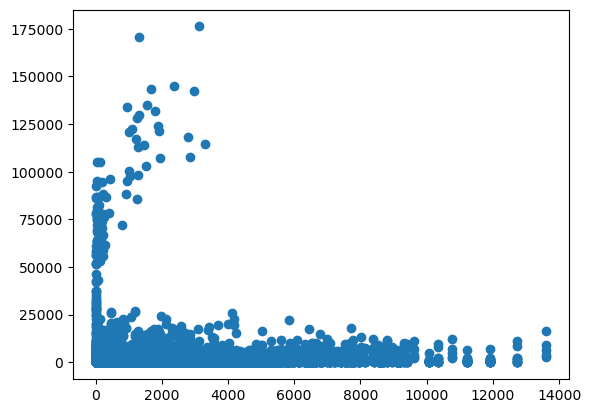

In [41]:
import matplotlib.pyplot as plt
plt.scatter(test_merge['SWE_depth_m_AREA_SCALED'], test_merge['volume'])

# Look at site level

In [45]:
test_merge[test_merge['site_id'].isin(mflow_orig['site_id'])]

,site_id,week_start_date,SWE_depth_m,SWE_depth_m_AREA_SCALED,water_year,forecast_year,volume
23275,skagit_ross_reservoir,2012-04-01,0.806156,6596.939251,2012,2012.0,2033.12
23276,skagit_ross_reservoir,2013-04-01,0.217938,1783.429296,2013,NaN,NaN
23277,skagit_ross_reservoir,2014-04-01,0.191720,1568.883879,2014,2014.0,1974.59
23278,skagit_ross_reservoir,2015-04-01,0.057414,469.826993,2015,NaN,NaN
23279,skagit_ross_reservoir,2016-04-01,0.249222,2039.437061,2016,2016.0,2222.79
23280,skagit_ross_reservoir,2017-04-01,0.513110,4198.882965,2017,NaN,NaN
23281,skagit_ross_reservoir,2018-04-01,0.272510,2230.004212,2018,2018.0,2121.26
23282,skagit_ross_reservoir,2019-04-01,0.348424,2851.223063,2019,NaN,NaN
23283,skagit_ross_reservoir,2020-04-01,0.268056,2193.555214,2020,2020.0,1978.43
23284,skagit_ross_reservoir,2021-04-01,0.267759,2191.126002,2021,NaN,NaN


In [54]:
all_metad

,site_id,nrcs_name,usgs_id,elevation,latitude,longitude,season_start_month,season_end_month
0,hungry_horse_reservoir_inflow,Hungry Horse Reservoir Inflow,12362500.0,3040.0,48.35663,-114.03762,4,7
1,snake_r_nr_heise,Snake R nr Heise,13037500.0,5015.0,43.61250,-111.66000,4,7
2,pueblo_reservoir_inflow,Pueblo Reservoir Inflow,7099400.0,4740.0,38.27167,-104.71803,4,7
3,sweetwater_r_nr_alcova,Sweetwater R nr Alcova,6639000.0,5890.0,42.48996,-107.13394,4,7
4,missouri_r_at_toston,Missouri R at Toston,6054500.0,3906.0,46.14604,-111.42052,4,7
...,...,...,...,...,...,...,...,...
613,06329500:MT:USGS,Yellowstone R nr Sidney,06329500,1881.0,47.67835,-104.15660,4,7
614,11418000:CA:USGS,Yuba R bl Englebright Dam nr Smartville,11418000,279.0,39.23517,-121.27413,4,7
615,15356000:AK:USGS,Yukon R at Eagle,15356000,850.0,64.78917,-141.20009,4,7
616,15453500:AK:USGS,Yukon R nr Stevens Village,15453500,240.0,65.87510,-149.72035,4,7


In [53]:
swe_volumes_area

,site_id,week_start_date,SWE_depth_m,SWE_depth_m_AREA_SCALED
0,00600:MT:USGS,1984-01-01,0.131783,3083.095768
1,00600:MT:USGS,1984-01-08,0.136744,3199.168775
2,00600:MT:USGS,1984-01-15,0.151629,3547.414299
3,00600:MT:USGS,1984-01-22,0.168284,3937.065544
4,00600:MT:USGS,1984-02-01,0.176614,4131.926686
...,...,...,...,...
1110559,skagit_ross_reservoir,2022-08-22,0.000263,2.152323
1110560,skagit_ross_reservoir,2022-09-01,0.000001,0.012093
1110561,skagit_ross_reservoir,2022-09-08,0.000000,0.000000
1110562,skagit_ross_reservoir,2022-09-15,0.000012,0.098095


In [46]:
mflow_orig['site_id']

0        hungry_horse_reservoir_inflow
1        hungry_horse_reservoir_inflow
2        hungry_horse_reservoir_inflow
3        hungry_horse_reservoir_inflow
4        hungry_horse_reservoir_inflow
                     ...              
17786           owyhee_r_bl_owyhee_dam
17787           owyhee_r_bl_owyhee_dam
17788           owyhee_r_bl_owyhee_dam
17789           owyhee_r_bl_owyhee_dam
17790           owyhee_r_bl_owyhee_dam
Name: site_id, Length: 17791, dtype: object

In [38]:
test_merge

,site_id,week_start_date,SWE_depth_m,SWE_depth_m_AREA_SCALED,water_year,forecast_year,volume
0,00600:MT:USGS,1984-04-01,0.234474,5485.589706,1984,NaN,NaN
1,00600:MT:USGS,1985-04-01,0.330904,7741.599855,1985,NaN,NaN
2,00600:MT:USGS,1986-04-01,0.250292,5855.656662,1986,NaN,NaN
3,00600:MT:USGS,1987-04-01,0.238200,5572.754344,1987,NaN,NaN
4,00600:MT:USGS,1988-04-01,0.256388,5998.278956,1988,NaN,NaN
...,...,...,...,...,...,...,...
23281,skagit_ross_reservoir,2018-04-01,0.272510,2230.004212,2018,2018.0,2121.26
23282,skagit_ross_reservoir,2019-04-01,0.348424,2851.223063,2019,NaN,NaN
23283,skagit_ross_reservoir,2020-04-01,0.268056,2193.555214,2020,2020.0,1978.43
23284,skagit_ross_reservoir,2021-04-01,0.267759,2191.126002,2021,NaN,NaN


In [34]:
flow_test

,site_id,forecast_year,volume
0,00600:MT:USGS,1996,8.947
1,00600:MT:USGS,1997,10.265
2,00600:MT:USGS,1998,6.685
3,00600:MT:USGS,1999,5.508
4,00600:MT:USGS,2000,5.893
...,...,...,...
50726,yampa_r_nr_maybell,2014,1185.976
50727,yampa_r_nr_maybell,2016,1130.275
50728,yampa_r_nr_maybell,2018,710.440
50729,yampa_r_nr_maybell,2020,927.480


In [234]:
pd.read_csv('assets/data/supplementary_nrcs_metadata.csv')

,nrcs_id,nrcs_name,usgs_id,elevation,latitude,longitude
0,12502500:WA:USGS,Ahtanum Ck at Union Gap,12502500,940,46.53596,-120.47340
1,08236000:CO:USGS,Alamosa Ck ab Terrace Reservoir,08236000,8600,37.37473,-106.33476
2,10164500:UT:USGS,American Fk ab Upper Powerplant,10164500,5950,40.44773,-111.68215
3,11446500:CA:USGS,American R A Fair Oaks CA,11446500,72,38.63546,-121.22773
4,12488500:WA:USGS,American R nr Nile,12488500,2700,46.97762,-121.16870
...,...,...,...,...,...,...
587,06329500:MT:USGS,Yellowstone R nr Sidney,06329500,1881,47.67835,-104.15660
588,11418000:CA:USGS,Yuba R bl Englebright Dam nr Smartville,11418000,279,39.23517,-121.27413
589,15356000:AK:USGS,Yukon R at Eagle,15356000,850,64.78917,-141.20009
590,15453500:AK:USGS,Yukon R nr Stevens Village,15453500,240,65.87510,-149.72035


In [231]:
# Create empty list
usbr_all = []

# Loop through years
for year in range(1985, 2025):
    print(f"#######Retreiving data for {year}#######")

    # Loop through forecasting sites
    for site in all_metad['site_id']:
        file_path = f"./assets/data/additional_sites/support_data/usgs_streamflow/FY{year}/{site}.csv"

        #  # Check if the file exists for the station
        if not os.path.exists(file_path):
            print(f"File not found for site {site}. Skipping...")
            continue

        # Read in daily flow data for the selected year
        flow_data = pd.read_csv(file_path)
        flow_data['site_id'] = site

        # Select data of interest
        flow_data = flow_data[['site_id', 'datetime', '00060_Mean']]

        # Append to list
        usbr_all.append(flow_data)

# Combine data
result = pd.concat(usbr_all, axis=0, ignore_index=True)

# Perform additional cleaning
result['datetime'] = pd.to_datetime(result['datetime']).dt.strftime('%Y-%m-%d')
result['00060_Mean'] = np.where(result['00060_Mean'] == -999999, np.nan, result['00060_Mean'])

# Filter to years of interest
result_week = result.copy()
result_week['date'] = pd.to_datetime(result['datetime']).dt.date
result_week = result_week[pd.to_datetime(
    result_week['date']) >= pd.Timestamp("1984-01-01")]

# Define start and end dates
start_date = datetime.date(1984, 1, 1)
end_date = datetime.date(2024, 1, 1)

# Initialize an empty list to store weeks
week_list = []

# Generate weeks between start_date and end_date
current_date = start_date
while current_date < end_date:
    for day in [1, 8, 15, 22]:
        week = current_date + datetime.timedelta(days=(day - current_date.weekday() - 1))
        if week < end_date:
            week_list.append(week.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=7)
    
# Function to round down the day to the nearest value less than or equal to the day
def round_day_down(date):
    day = date.day
    nearest_values = [1, 8, 15, 22]

    # Find the nearest value less than or equal to the day
    rounded_day = max(filter(lambda x: x <= day, nearest_values))
    return date.replace(day=rounded_day)

 # Create a new column 'Rounded_Day_Column' based on 'Date_Column'
result_week['week_start_date'] = result_week['date'].apply(round_day_down)
result_week = result_week.drop(['date', 'datetime'], axis=1)

# Aggregate by week
result_week = result_week.groupby(
    ['site_id','week_start_date']).mean().reset_index()

# Export data
result_week.to_csv('./assets/data/additional_sites/support_data/usgs_streamflow.csv', index=False)

#######Retreiving data for 1985#######


KeyError: 'site_id'

### Combine Data and Export

In [218]:
# Link area to snow volume data
swe_volumes_area = swe_volumes_week.merge(
    gdf_join[['site_id','SUB_AREA']], how='left', on='site_id')

# Scale snow volume by area
swe_volumes_area['SWE_depth_m_AREA_SCALED'] = swe_volumes_area[
    'SWE_depth_m'] * swe_volumes_area['SUB_AREA']

# Drop area column
swe_volumes_area = swe_volumes_area.drop('SUB_AREA', axis=1)

# Export data
all_metad.to_csv("assets/data/additional_sites/metadata.csv", index=False)
swe_volumes_area.to_csv("assets/data/additional_sites/swann_swe.csv", index=False)
all_mflow.to_csv("assets/data/additional_sites/train_monthly_naturalized_flow.csv", index=False)
gdf_join.to_csv("assets/data/additional_sites/hydrobasins_summary.csv", index=False)

In [8]:
# Transform into delta models